
<div style="width:30%; margin: auto;">

# Immozila at your service

</div>


<div style="width:60%; margin: auto;">

![house](house.png)  

</div>
<div style="width:10%; margin: auto;">


![app](app.png)  
</div>

# Imports and Loading data

In [75]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
import plotly.express as px
import plotly.graph_objects as go
import semfunction as sf
import numpy as np
import jensfunction as js
# Get the current directory (analyses folder)
current_dir = os.getcwd()

# Navigate up one directory to reach the parent directory (which contains the data folder)
parent_dir = os.path.dirname(current_dir)

# Define the file paths relative to the parent directory using os.path.join
clean_huis_te_koop_path = os.path.join(parent_dir, "data", "cleaned", "clean_house.csv")
clean_apartement_te_koop_path = os.path.join(parent_dir, "data", "cleaned", "clean_app.csv")

house = pd.read_csv(clean_huis_te_koop_path, sep=",")
app = pd.read_csv(clean_apartement_te_koop_path, sep=",")



## Questions to answer

- How many observations and features do you have?
- What is the proportion of missing values per column?
- Which variables would you delete and why?
- What variables are most subject to outliers?
- How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?
- What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?
- How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?
- How are the number of properties distributed according to their surface?
- Which five variables do you consider the most important and why?
- What are the least/most expensive municipalities in Belgium/Wallonia/Flanders? (in terms of price per m², average price, and median price)

### Q1 How many observations and features do you have?

In [76]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px


# Define function to count non-null values in each column
def count_non_null_values(df):
    return df.notnull().sum()

# Get colors from px.colors.qualitative.swatches()
colors = px.colors.qualitative.swatches()

# Create figure with subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Number of Observations - Houses", 
                                                    "Number of Observations - Apartments", 
                                                    "Features and occurrences - Houses", 
                                                    "Features and occurrences - Apartments"))

# Plot 1: Number of observations for house dataset
fig.add_trace(go.Bar(x=['House'], y=[len(house)], marker=dict(color=px.colors.qualitative.Alphabet[13])), row=1, col=1)

# Plot 2: Number of observations for apartment dataset
fig.add_trace(go.Bar(x=['Apartment'], y=[len(app)], marker=dict(color=px.colors.qualitative.Pastel[8])), row=1, col=2)

# Plot 3: Number of non-null values for each feature in house dataset
count_house = count_non_null_values(house)
fig.add_trace(go.Bar(x=count_house.index, y=count_house.values, marker=dict(color=px.colors.qualitative.Alphabet[13])), row=2, col=1)

# Plot 4: Number of non-null values for each feature in apartment dataset
count_apartment = count_non_null_values(app)
fig.add_trace(go.Bar(x=count_apartment.index, y=count_apartment.values, marker=dict(color=px.colors.qualitative.Pastel[8])), row=2, col=2)

# Update layout
fig.update_layout(showlegend=False, title_text="Number of Observations and Features", title_x=0.5)

# Set the same y-axis range for Plot 1 and Plot 2
max_observation_value = max(len(house), len(app))
fig.update_yaxes(range=[0, max_observation_value], row=1, col=1)
fig.update_yaxes(range=[0, max_observation_value], row=1, col=2)
fig.update_yaxes(range=[0, max_observation_value], row=2, col=1)
fig.update_yaxes(range=[0, max_observation_value], row=2, col=2)
fig.update_xaxes(tickangle=45, row=2, col=1)
fig.update_xaxes(tickangle=45, row=2, col=2)


# Show plot
fig.show()

- For the `houses` we have 11394 observations and 25 features
- For the `apartments` we have 9342 observations and 24 features (as surface of good is always empty for apartments)


### Q2 What is the proportion of missing values per column?

- While certain columns exhibit a notable prevalence of missing values, this occurrence often stems from the practice wherein the absence of corresponding attributes results in the omission of data input by the individuals responsible for data entry.

- There is however one variable showing a big difference between houses and apartments which is surface of good, showing no input anywhere in the apartments, and therefore one of the attributes best left out of the model.

In [77]:
def make_bar_perc_plotly(df, colors=None, title="Missing Values Proportion"):
    df_missing = pd.DataFrame()
    df_missing["not-missing"] = df.count()/len(df)*100
    df_missing["missing"] = df.isnull().sum()/len(df)*100

    fig = px.bar(df_missing, x=df_missing.index, y=df_missing.columns, title=title, color_discrete_map=colors)
    fig.show()

house_custom_colors = {"not-missing": px.colors.qualitative.Alphabet[13], "missing": px.colors.qualitative.T10[9]}
make_bar_perc_plotly(house, colors=house_custom_colors, title="Missing Values Proportion - House")

In [78]:
app_custom_colors = {"not-missing": px.colors.qualitative.Pastel[8], "missing": px.colors.qualitative.T10[9]}
make_bar_perc_plotly(app, colors=app_custom_colors, title="Missing Values Proportion - Apartment")

### Q3 Which variables would you delete and why?


| Variable to remove      | Reason |
| ----------- | ----------- |
| surface_of_good | for apartments as surface of good is always empty   |
| property_id | as all records have a unique property_id |
| property_type | as for house this is always house and for apartment this is always apartement |
| terrace | booleans 1/0, we can deduct from terrace surface |
| garden | booleans 1/0, we can deduct from garden surface |

### Q4 What variables are most subject to outliers?


In [79]:
def count_iqr_outliers (df, column_name):
    """
    Counts outliers based on interquartile range
    """
    seventy_fifth = df[column_name].quantile(0.75)
    twenty_fifth = df[column_name].quantile(0.25)
    iqr = seventy_fifth-twenty_fifth
    upper = seventy_fifth + (1.5*iqr)
    lower = twenty_fifth - (1.5*iqr)
    outliers = df.loc[(df[column_name] >= upper)|(df[column_name] <= lower)]
    count_outliers = outliers.shape[0]
    return count_outliers

print(count_iqr_outliers(app, "price"))

quantitative = ['price', 'number_of_rooms', 'living_area', 'terrace_area', 'garden_area', 'surface_of_good','number_of_facades']

d={}
for col in quantitative:
    d[col] = [count_iqr_outliers(app, col)]

df = pd.DataFrame(data=d)
df= df.transpose()
df.rename(columns={0: "outliers_count"}, inplace=True)
df.sort_values(by='outliers_count', ascending=False, inplace=True)

fig = px.bar(df, x=df.index, y="outliers_count", color=df.index)
fig.update_layout(barmode='group', width=800)
fig.update_traces(width=0.5)
fig.update_layout(yaxis=dict(title='Count'))
fig.update_layout(xaxis=dict(title='Variable'))
fig.update_layout(title='Outliers per variable - Apartments')


898


In [80]:
d={}
for col in quantitative:
    d[col] = [count_iqr_outliers(house, col)]

df = pd.DataFrame(data=d)
df= df.transpose()
df.rename(columns={0: "outliers_count"}, inplace=True)
df.sort_values(by='outliers_count', ascending=False, inplace=True)

fig = px.bar(df, x=df.index, y="outliers_count", color=df.index)
fig.update_layout(barmode='group', width=800)
fig.update_traces(width=0.5)
fig.update_layout(yaxis=dict(title='Count'))
fig.update_layout(xaxis=dict(title='Variable'))
fig.update_layout(title='Outliers per variable - Houses')

### Q5 How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?


### Qualitative variables (18)

- property_id
- locality_name
- postal_code
- latitude
- longitude
- main_city
- province
- property_type --> transform them to numerical values to be able to use them for correlation (give a number for each property type)   
- property_subtype --> transform them to numerical values to be able to use them for correlation (give a number for sub property type)
- type_of_sale     
- kitchen_type     
- fully_equipped_kitchen
- furnished
- open_fire
- terrace
- garden
- state_of_building --> transform them to numerical values to be able to use them for correlation (give a number for each state)
- swimming_pool

### Quantitative variables (7)
- price
- number_of_rooms
- living_area
- terrace_area
- garden_area
- surface_of_good
- number_of_facades

### Q6 What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?

`Anwser`: 

There is a correlation between price and living area, garden space, and the surface area of goods. The rationale behind these correlations is straightforward. When the price increases, it follows logically that the living space expands. Furthermore, the rise in price also leads to an increase in the land area, which consequently impacts the size of the garden. Therefore, both the surface area of goods and the garden space are influenced by changes in price.


Text(0.5, 1.0, 'correlation in houses')

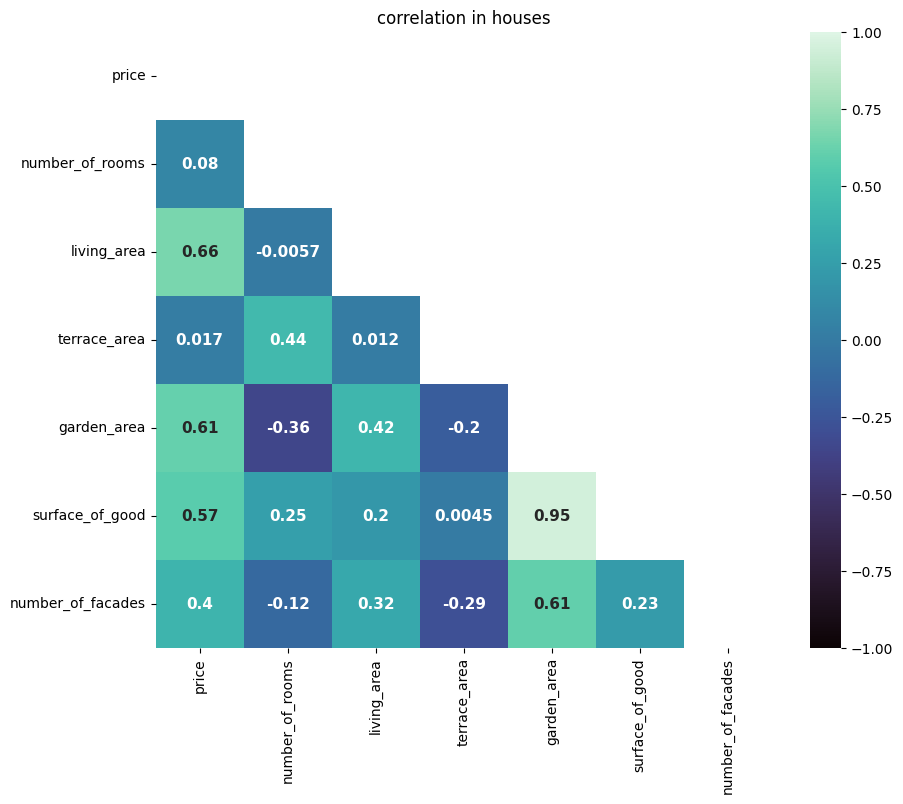

In [81]:
limburg = house[house["province"]=="limburg"]
limburgs = limburg[limburg["state_of_building"]=="GOOD"]
limburgcorr = sf.drop_object_columns(limburgs)
mask = np.triu(np.ones_like(limburgcorr.corr()))
plt.figure(figsize=(10, 8))
sns.heatmap(limburgcorr.corr(), annot=True, vmin=-1, vmax=1, annot_kws={"fontsize":11, "fontweight":"bold"}, square=True, mask=mask, cmap='mako').set_title("correlation in houses")

Text(0.5, 1.0, 'correlation between price and living area')

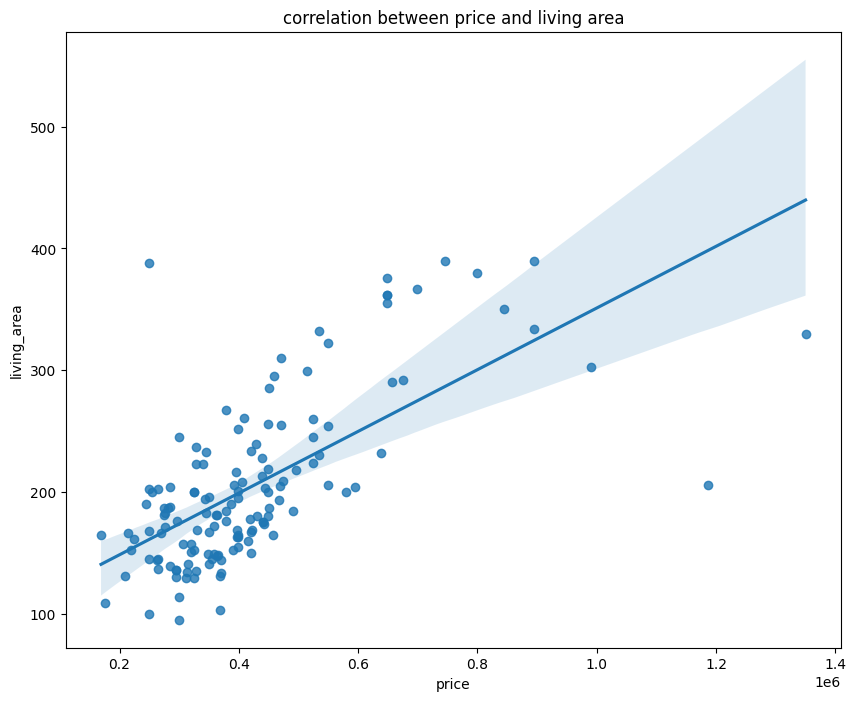

In [82]:
plt.figure(figsize=(10, 8))
sns.regplot(data = limburgcorr, x="price", y="living_area").set_title("correlation between price and living area")

Text(0.5, 1.0, 'correlation between price and garden area')

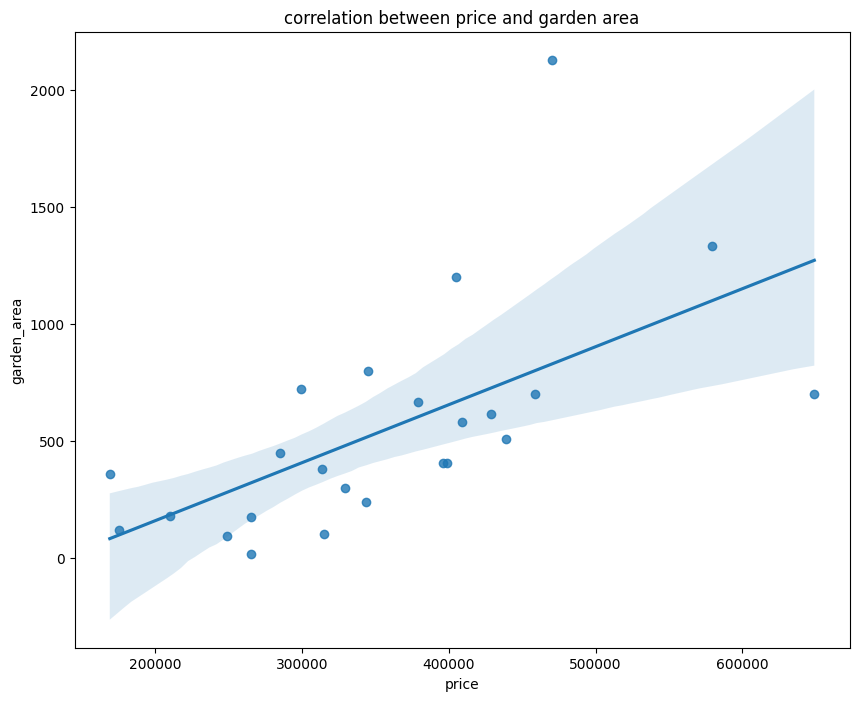

In [83]:
plt.figure(figsize=(10, 8))
sns.regplot(data = limburgcorr, x="price", y="garden_area").set_title("correlation between price and garden area")

Text(0.5, 1.0, 'correlation between price and surface of good')

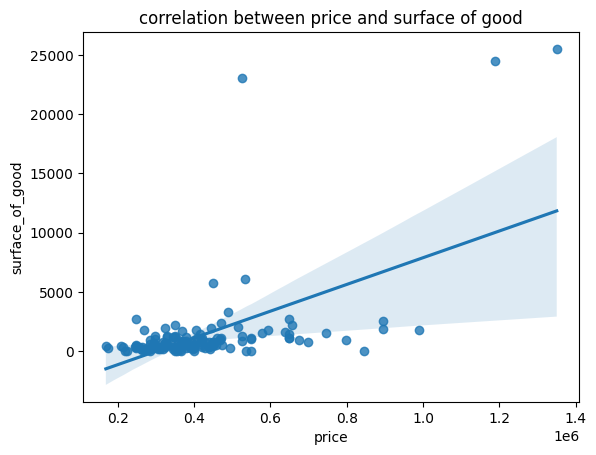

In [84]:
sns.regplot(data = limburgcorr, x="price", y="surface_of_good").set_title("correlation between price and surface of good")

### Q7 How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?

`Anwser`: 
There are correlations extending beyond price, particularly evident in the linear relationships between the surface area of goods and garden space, as well as the number of facades and garden area.
As the land surface area increases, there is a corresponding expansion in the associated garden area. Similarly, a higher number of facades, or free walls, results in an expansion of the garden space.

Text(0.5, 1.0, 'correlation between garden and surface')

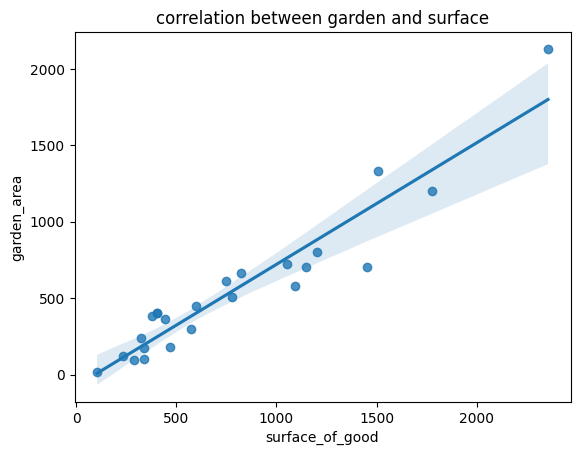

In [85]:
sns.regplot(data = limburgcorr, x="surface_of_good", y="garden_area").set_title("correlation between garden and surface")


Text(0.5, 1.0, 'correlation between garden and facades')

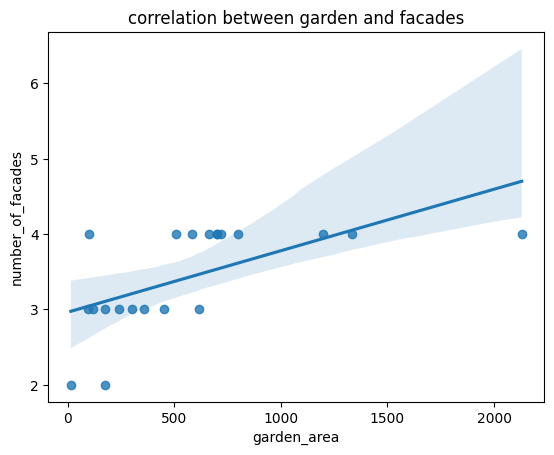

In [86]:
sns.regplot(data = limburgcorr, x="garden_area", y="number_of_facades").set_title("correlation between garden and facades")

### Q8 How are the number of properties distributed according to their surface?


`Anwser`: 
- The distribution of the living area of apartments is right-skewed. 
- This is an expected effect of the standards implemented to the housing in Belgium: 
   - the lower treshold for the apartment area is 18 m² (24 m² for the properties that were built after 2008), 
   - at the same time, there is no upper treshold for the living area, meaning that the extremely large apartments, e.g. penthouses will be present on the market. 
   - The most common size of an apartment for sale is around 100 m².

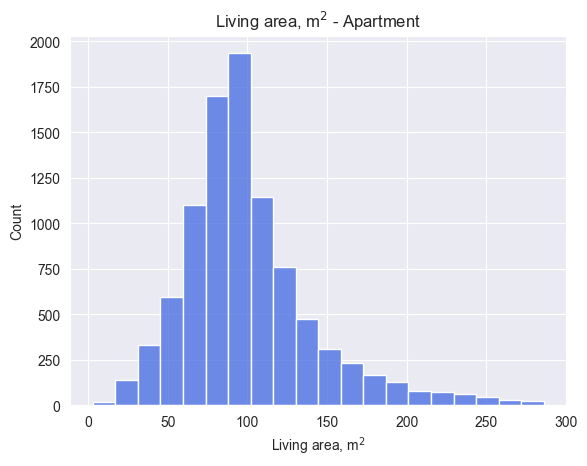

In [87]:
sns.set_style("darkgrid")
sns.histplot(app, x="living_area", bins=20, color='royalblue')
plt.xlabel("Living area, m$^2$")
plt.title("Living area, m$^2$ - Apartment")
plt.show()

- As for houses, we can observe similar right skew, which is, again, determined by local size regulations for very small houses. 
- Houses are usually larger than apartments: the living area of the majority of house-type properties on the market today reached the size of around 150 m².

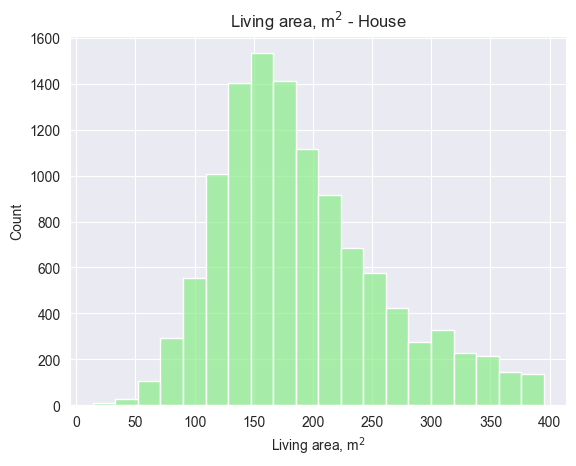

In [88]:
sns.set_style("darkgrid")
sns.histplot(house, x="living_area", bins=20, color='lightgreen')
plt.xlabel("Living area, m$^2$")
plt.title("Living area, m$^2$ - House")
plt.show()

### Q9 Which five variables do you consider the most important and why?

HOUSES
- living area
- surface of goods (only for houses)
- province
- number of facades
- ...

APARTMENTS

- living area
- terrace area
- province
- garden area
- ...


### Q10 What are the least/most expensive municipalities in Belgium/Wallonia/Flanders? (in terms of price per m², average price, and median price)

`Anwser`: 
- The residences commanding higher market values predominantly gravitate towards prominent urban centers in Belgium. 
- Notably, Brussels, Antwerp, Knokke, and Luik exhibit an elevated average pricing paradigm for residential properties. 
- Conversely, more economical housing options are inclined to be positioned predominantly in the southern regions of Belgium, specifically within the Wallonian territory.

In [89]:
house["price_per_m2"] = house["price"]/house["living_area"]
app["price_per_m2"] = app["price"]/app["living_area"]

house_grouped = js.aggregate_function(house)
app_grouped = js.aggregate_function(app)

### Average Price per Province
#### Houses

In [90]:
js.make_map(house_grouped)

#### Apartments

In [91]:
js.make_map(app_grouped)

In [92]:
# Filtered out the highest price observations
grouped_locality_house = js.aggregate_locality(house[house["price"]<= 2000000])
grouped_locality_app = js.aggregate_locality(app[app["price"]<= 2000000])

### Heatmap showing distribution of Average Price per Municipality
#### Houses

In [93]:
js.make_heatmap(grouped_locality_house, "mean_price",radius=10)

#### Apartments

In [94]:
js.make_heatmap(grouped_locality_app, "mean_price",radius=10)

### Heatmap showing distribution of Median Price per Municipality
#### Houses

In [95]:
js.make_heatmap(grouped_locality_house, "median_price",radius=10)

#### Apartments

In [96]:
js.make_heatmap(grouped_locality_app, "median_price",radius=10)

### Heatmap showing distribution of Average Price per m2 per Municipality
#### Houses

In [97]:
js.make_heatmap(grouped_locality_house, "mean_price_m2",radius=10)

#### Apartments

In [98]:
js.make_heatmap(grouped_locality_app, "mean_price_m2",radius=10)